# **Econometría Aplicada Avanzada**

## Práctica calificada 1: Diferencias en Diferencias

## **Integrantes**

1. Gianfranco Romero (20196091)
2. Shaska Guevara (20171597)
3. Micaela Gutierrez (20171488)
4. Eduardo Ramírez (20162936)
5. Fernando Mendoza (20105246)

# **Librerías**

Instalamos las librerías

In [ ]:
!pip install csdid
!pip install pandas
!pip install statsmodels
!pip install linearmodels
!pip install matplotlib
!pip install pyfixest
!pip install drdid
!pip install requests
!pip install pyreadstat
!pip install lightgbm

Y luego las importamos

In [ ]:
from csdid.att_gt import ATTgt
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
import csdid
import pyfixest as pf
import requests
import pyreadstat
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree


Tenemos data de un AB test y de la lista de paises correspondiente a cada entrada. Este A/B test fue hecho para ver si un usuario era clasificado como "convert". La variable de tratamiento es landing_page. Define si el usuario vio la pagina web version antigua o moderna. Luego, tenemos la variable grupo que define a que grupo fue asignado el usuario, tratamiento o control

### **Pregunta 1:** Merge de ambas bases de datos basado en la variable user_id.

In [ ]:
# Creamos url's para cada base de datos
url_ab_data = "https://github.com/GianfrancoRomero/data_pc4_econometria/raw/refs/heads/main/ab_data.csv"
url_countries = "https://github.com/GianfrancoRomero/data_pc4_econometria/raw/refs/heads/main/countries.csv"

# Importamos las bases de datos
ab_data = pd.read_csv(url_ab_data)
countries = pd.read_csv(url_countries)

In [ ]:
# Hacemos el merge de ambas bases de datos en base a 'user_id'

data = countries.merge(ab_data, how='inner', on='user_id')
data.head()

,user_id,country,timestamp,group,landing_page,converted
0,834778,UK,08:43.3,control,old_page,0
1,928468,US,44:16.4,treatment,new_page,0
2,822059,UK,04:14.7,treatment,new_page,1
3,711597,UK,14:24.8,control,old_page,0
4,710616,UK,14:44.0,treatment,new_page,0


### **Pregunta 2:** Nos quedamos con aquellas observaciones cuya asignación fue perfecta.  Aquellos que pertenecen al grupo de los tratados deben haber visto la pagina nueva y los que pertenecen al control debieron ver la pagina antigua. Esto es muy importante. Esto define los siguientes resultados

In [ ]:
# Extraemos solo aquellas filas que cumplen con los requisitos correctos para los grupos de control y tratamiento

treatment_data = data[(data['group'] == 'treatment') & (data['landing_page'] == 'new_page')]
control_data = data[(data['group'] == 'control') & (data['landing_page'] == 'old_page')]

In [ ]:
# Juntamos todas las filas

full_data = pd.concat([treatment_data, control_data], axis=0, ignore_index=True)
full_data.head()

,user_id,country,timestamp,group,landing_page,converted
0,928468,US,44:16.4,treatment,new_page,0
1,822059,UK,04:14.7,treatment,new_page,1
2,710616,UK,14:44.0,treatment,new_page,0
3,909908,UK,44:26.3,treatment,new_page,0
4,811617,US,42:11.9,treatment,new_page,1


In [ ]:
# Comprobamos que ambas columnas cumplen con las combinaciones requeridas

full_data.groupby(['group', 'landing_page']).size().unstack()

landing_page,new_page,old_page
group,,
control,NaN,145274.0
treatment,145315.0,NaN


### **Pregunta 3:** Construir el propensity score de los tratados y controles usando un modelo logistico (aquí tienen que utilizar la variable país y el timestamp en formato númerico. esta variable es la cantidad de tiempo que pasan en la pagina. Usen la variable en formato numérico).. Múestrelos en un plot para ambos grupos, tratados y controles (Histograma). Revisar tutorial.

In [ ]:
# Convertimos 'timestamp' a formato numérico (ejemplo: segundos desde el inicio del AB test)
full_data['timestamp_numeric'] = pd.to_datetime(
    full_data['timestamp'], errors='coerce', format='%H:%M.%S'
).astype(np.int64) / 1e9

In [ ]:
# Eliminamos filas con valores inválidos en 'timestamp'
full_data = full_data.dropna(subset=['timestamp_numeric'])

In [ ]:
# Codificamos la variable 'country' en formato numérico
label_encoder = LabelEncoder()
full_data['country_encoded'] = label_encoder.fit_transform(full_data['country'])

In [ ]:
# Preparamos las variables independientes (X) y dependiente (y)
X = full_data[['timestamp_numeric', 'country_encoded']]
y = (full_data['group'] == 'treatment').astype(int)  # 1 para tratados, 0 para controles

In [ ]:
# Ajustamos un modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [ ]:
# Calculamos el propensity score
full_data['propensity_score'] = log_reg.predict_proba(X)[:, 1]

In [ ]:
# Visualizamos los propensity scores en histogramas separados por grupo
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

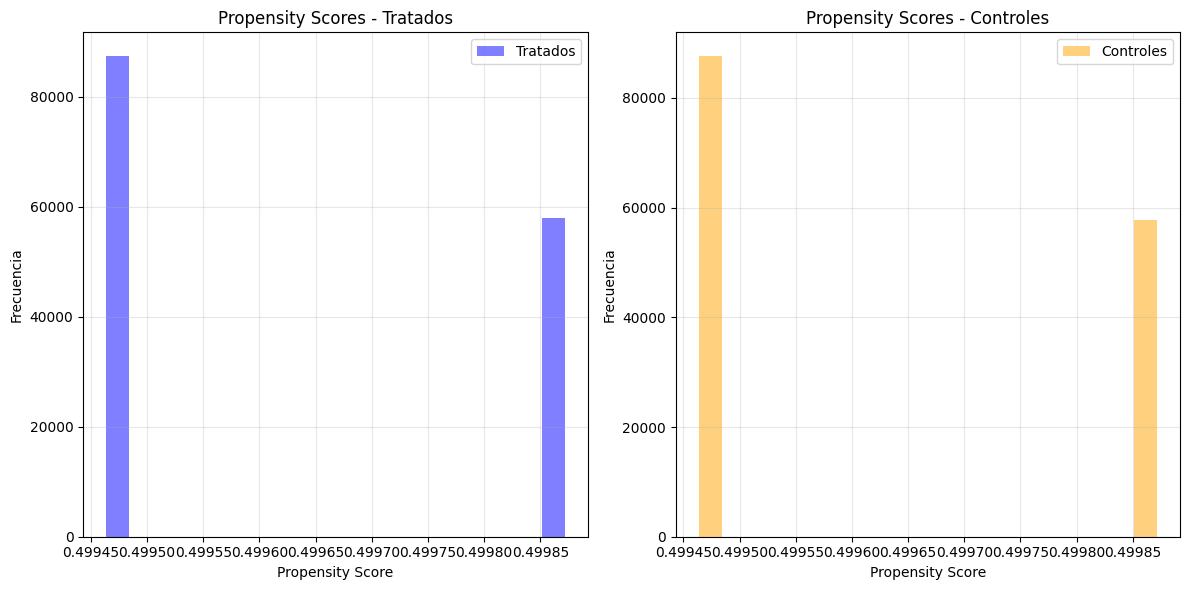

In [ ]:
# Creamos una figura con 1 fila y 2 columnas para los subgráficos
plt.figure(figsize=(12, 6))

# Primer gráfico: Propensity scores de los tratados
plt.subplot(1, 2, 1)  # (filas, columnas, índice del gráfico)
plt.hist(
    full_data[full_data['group'] == 'treatment']['propensity_score'],
    bins=20, alpha=0.5, label='Tratados', color='blue'
)
plt.title('Propensity Scores - Tratados')
plt.xlabel('Propensity Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)

# Segundo gráfico: Propensity scores de los controles
plt.subplot(1, 2, 2)  # (filas, columnas, índice del gráfico)
plt.hist(
    full_data[full_data['group'] == 'control']['propensity_score'],
    bins=20, alpha=0.5, label='Controles', color='orange'
)
plt.title('Propensity Scores - Controles')
plt.xlabel('Propensity Score')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)

# Ajustamos el layout para que no se solapen los gráficos
plt.tight_layout()

# Mostramos la figura
plt.show()

### **Pregunta 4:** Construye el histograma de Y* y señale la media en el plot. Revise tutorial

In [ ]:
print("Columnas en el dataset full_data:")
print(full_data.columns)

Columnas en el dataset full_data:
Index(['user_id', 'country', 'timestamp', 'group', 'landing_page', 'converted',
       'timestamp_numeric', 'country_encoded', 'propensity_score'],
      dtype='object')


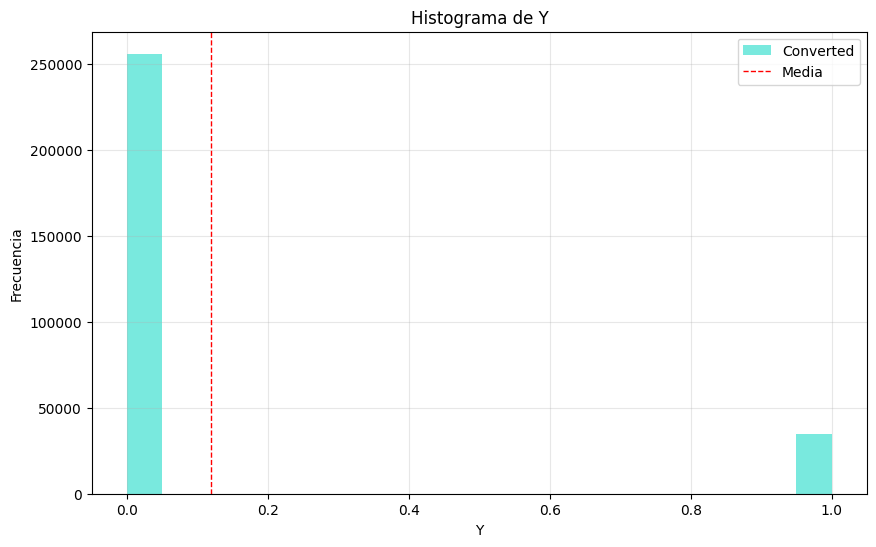

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(full_data['converted'], bins=20, alpha=0.7, color='turquoise', label='Converted')
plt.axvline(full_data['converted'].mean(), color='red', linestyle='dashed', linewidth=1, label='Media')
plt.title('Histograma de Y')
plt.xlabel('Y')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### **Pregunta 5:** Muestre el plot del tree generado para el modelo usando como covariables la variable pais y el timestamp.

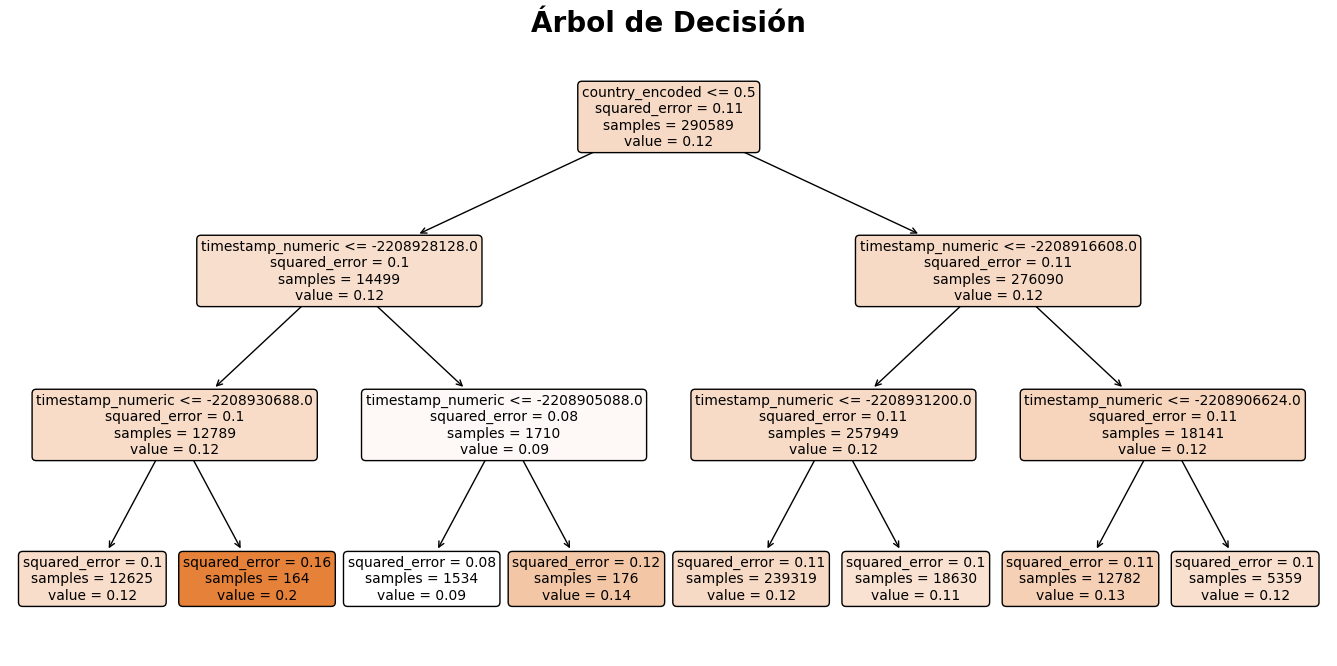

In [ ]:
# Preparamos las variables X (covariables) e y (variable objetivo)
X_tree = full_data[['country_encoded', 'timestamp_numeric']]
y_tree = full_data['converted']  # Variable objetivo

# Ajustamos un modelo de árbol de decisión
decision_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
decision_tree.fit(X_tree, y_tree)

# Visualizamos el árbol de decisión
plt.figure(figsize=(17, 8))
plot_tree(decision_tree, feature_names=['country_encoded', 'timestamp_numeric'], filled=True, rounded=True, fontsize=10, precision=2)
plt.title('Árbol de Decisión', fontsize=20, weight='bold')
plt.show()

### **Pregunta 6:** Repita 5 pero con la libreria econml utilizando SingleTreeCateInterpreter.

In [ ]:
!pip install econml==0.13.0

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
np.int = np.int64

In [ ]:
!pip install econml --upgrade


  Using cached econml-0.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (38 kB)
Using cached econml-0.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)
  Attempting uninstall: econml
    Found existing installation: econml 0.13.0
    Uninstalling econml-0.13.0:
      Successfully uninstalled econml-0.13.0


In [ ]:
# Suponiendo que tu dataframe se llama 'df'
full_data.head()

,user_id,country,timestamp,group,landing_page,converted,timestamp_numeric,country_encoded,propensity_score
0,928468,US,44:16.4,treatment,new_page,0,-9.223372e+09,2,0.499464
1,822059,UK,04:14.7,treatment,new_page,1,-2.208974e+09,1,0.499872
2,710616,UK,14:44.0,treatment,new_page,0,-2.208936e+09,1,0.499872
3,909908,UK,44:26.3,treatment,new_page,0,-9.223372e+09,1,0.499464
4,811617,US,42:11.9,treatment,new_page,1,-9.223372e+09,2,0.499464


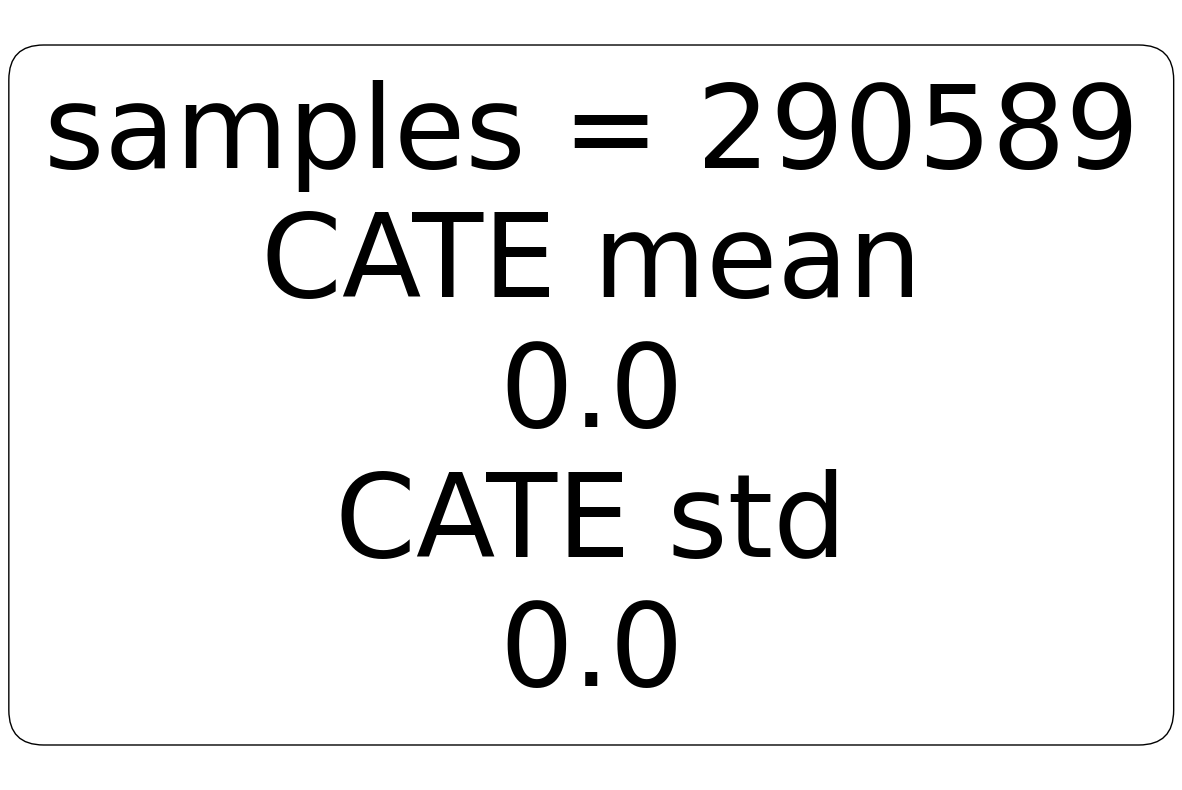

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que full_data ya está definido y contiene los datos necesarios
required_columns = ['timestamp_numeric', 'country_encoded','converted','group']
if not all(column in full_data.columns for column in required_columns):
    raise ValueError("El DataFrame no contiene las columnas necesarias.")

# Preparamos las variables predictoras (X) y la variable objetivo (y)
X_tree = full_data[['timestamp_numeric','country_encoded']]
y_tree = full_data['converted'] == 'treatment'
T = full_data['group'].apply(lambda x: 1 if x == 'treatment' else 0)

# Crear y entrenar el modelo CATE
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                featurizer=None,
                discrete_treatment=True,
                random_state=123)
# Ajustar el modelo (X: características, Y: resultado, T: tratamiento)
est.fit(Y=y_tree, T=T, X=X_tree)

# Crear el intérprete y ajustarlo
interpreter = SingleTreeCateInterpreter(max_depth=3)
interpreter.interpret(est, X_tree)

# Visualizar el árbol generado
plt.figure(figsize=(15, 10))
interpreter.plot(feature_names=['timestamp_numeric', 'country_encoded', 'converted'])  # Usamos los nombres de las columnas
plt.show()

### **Pregunta 7:** Interprete resultados y compare la imagen en 6 con la imagen en 5. Utilice los términos técnicos y revise la literatura para explicar a detalle que esta haciendo este causal tree y cual es la diferencia con decision trees. Sean precisos al definir que es una honest tree y las ventajas sobre el árbol generado por decision tree.

La imagen 6 muestra un Causal Tree, que sirve para analizar cómo varía el efecto promedio del tratamiento (CATE) entre diferentes grupos de la población. En este caso, los resultados indican que el valor promedio del CATE y su desviación estándar son ambos 0.0. Esto significa que no se encontraron diferencias en el impacto del tratamiento entre los subgrupos, lo cual puede deberse a dos cosas: o el efecto del tratamiento es uniforme en toda la población, o no hay suficiente información en los datos para detectar esas diferencias.

Por otro lado, en la imagen 5 tenemos un Árbol de Decisión tradicional. Este modelo se usa para hacer predicciones dividiendo los datos de manera que se minimice el error cuadrático promedio dentro de cada nodo. El Árbol de Decisión no está diseñado para responder preguntas causales; su único objetivo es identificar patrones que expliquen la variación en los datos.

Aquí es donde aparece la gran diferencia entre los dos enfoques. El Causal Tree se construye específicamente para responder preguntas causales, como "¿Cómo cambia el efecto del tratamiento dependiendo del grupo?". Además, utiliza algo llamado Honest Trees, que divide los datos en dos partes: una para decidir cómo dividir los nodos y otra para estimar los efectos dentro de esos nodos. Este método evita el sobreajuste y hace que las estimaciones causales sean más confiables.

En comparación, el Árbol de Decisión (imagen 5) no separa los datos de esta manera y, por tanto, no puede garantizar que sus resultados sean útiles para analizar causalidad. Básicamente, es muy bueno prediciendo, pero no nos dice nada sobre qué causa qué.

En resumen, mientras el Árbol de Decisión solo busca patrones para predecir, el Causal Tree está enfocado en entender cómo varía el efecto del tratamiento. El hecho de que en la imagen 6 el CATE sea 0.0 nos indica que no hay heterogeneidad en los efectos, o simplemente que no había suficiente información en los datos para detectarla.